# **Background and Context**

The agricultural industry needs modernization to reduce manual labor.
Artificial Intelligence (AI) can revolutionize plant seedling identification and monitoring.
AI and Deep Learning shorten the time and effort required for these tasks.
This leads to improved crop yields and frees up human involvement.
The integration of AI in agriculture promotes sustainability.
It transforms the industry, enhances productivity, and meets growing demands.

### **Objective**

As a Data Scientist, I need to build a CNN model to classify plant seedlings into 12 categories using data from Aarhus University and the University of Southern Denmark.

#### **Data Description**

~ Due to the large volume of data, the images were converted to numpy arrays and stored in and named **images.npy file** and the corresponding labels are also put into and named **Labels.csv**.

~ The dataset contains images of unique plants belonging to 12 different species.

*   The goal of the project is to create a classifier capable of determining a plant's species from an image.





##### **List of Plant species**


- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

## Connect to drive


In [3]:
# Mount Google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import necessary libraries

In [4]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs
import shutil
import random
from PIL import Image


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

### **Read the dataset**

In [6]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/Ailead/Deep learning/Assignment/Plant Seedling Project/images.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/Ailead/Deep learning/Assignment/Plant Seedling Project/Labels.csv')

In [7]:
# check labels
labels.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


In [8]:
# check unique of labels
np.unique(labels)

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype=object)

In [9]:
# Check how many unique plant species are in the data
labels["Label"].nunique()

12

There are indeed 12 classes in the Plant Seedling Dataset

### **Overview of the dataset**

Let's print the shape of the images and labels

In [10]:
print(images.shape)

print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


There are 4750 RGB images of shape 128 x 128 x 3 and labels is of same number of but one column

#### **Visualise image using OpenCV and matplotlib**

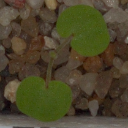

In [11]:
# Use openCV to show an image
cv2_imshow(images[4])

We notice the image is read in BGR order when we use OpenCv

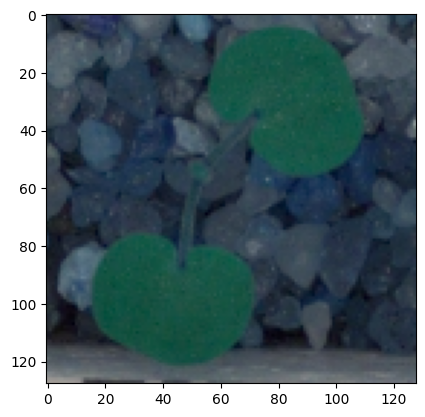

In [12]:
# Use Matplotlib to show the same image
plt.imshow(images[4]);

We notice the image is read in RGB order when we use matplotlib

#### **Image Processing**

In [13]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

In [14]:
def plot_images(images,labels):
  num_classes=12                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

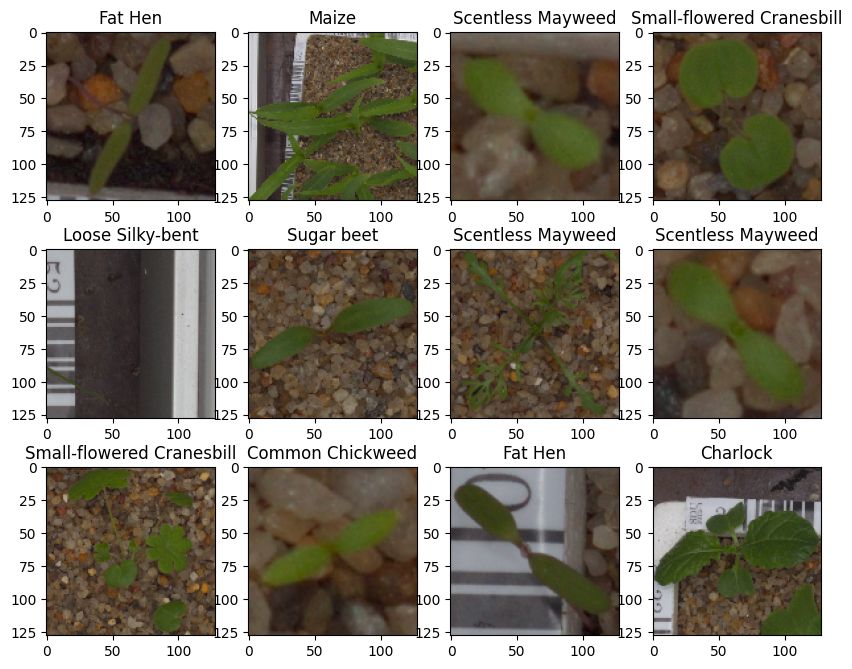

In [15]:
plot_images(images,labels)

### **Checking for data imbalance**

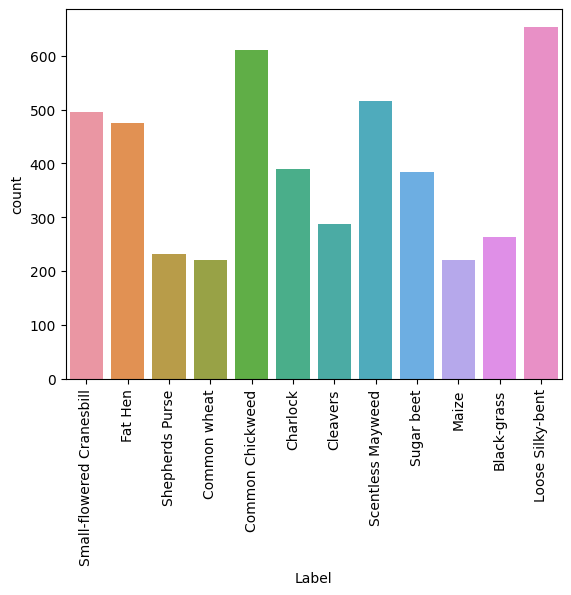

In [16]:
 sns.countplot(x ='Label', data = labels)
 plt.xticks(rotation=90);

The dataset exhibits an imbalance, which could potentially impact the model's performance.

The specie with the highest number of images is **Loose Silky-bent**, which comprises approximately 680 images. Following closely is **Common Chickweed** with around 600 images. Conversely, the specie with the fewest images is **Common Wheat**, which has approximately 230 images.

#### **Resizing images**

-  We reduce the image size from 128 to 70


In [17]:
images_decreased=[]
height = 70
width = 70
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append(cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

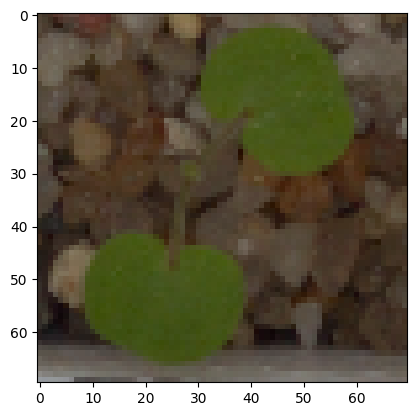

In [18]:
# show one image
plt.imshow(images_decreased[4]);

## Visualizing images using Gaussian Blur

In [19]:
# Applying Gaussian Blur to denoise the images
images_gb=[]
for i in range(len(images)):
  # gb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  images_gb.append(cv2.GaussianBlur(images[i], ksize =(3,3),sigmaX =  0))#ksize is kernel size/ filter being specified

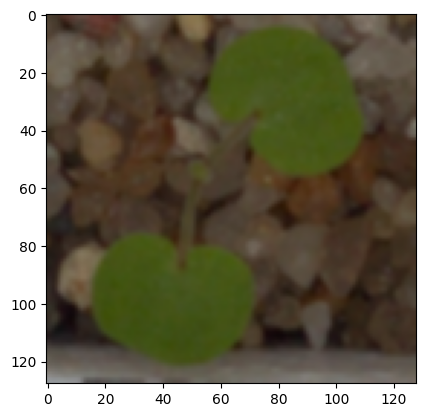

In [20]:
plt.imshow(images_gb[4]);

Though the image has been blurred using the blurring method the background is still visible

## **Splitting the dataset**

- As we have less images in our dataset, we will only use 15% of our data for testing, 15% of our data for validation and 70% of our data for training.
- We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.

In [21]:
# Splitting into training, validation and testing
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.15, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.15, random_state=42,stratify=y_temp)

In [22]:
# Check the shapes
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3431, 70, 70, 3) (3431, 1)
(606, 70, 70, 3) (606, 1)
(713, 70, 70, 3) (713, 1)


## **Making the data compatible:**

- Convert labels from names to one hot vectors
- Normalizing the values

#### **Encoding the target labels**

In [23]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [ ]:
# Check the shapes
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

### **Data Normalization**
Given that the pixel values of the image range from 0 to 255, we will use scaling as our normalization technique. To standardize the images and ensure values within the range of 0 to 1, we will divide all the pixel values by 255.

In [24]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0


## **Model Building - Convolutional Neural Network (CNN)**
Let's create our CNN models sequentially, where we will be adding the layers one after another.

##### **Architecture 1**

In [42]:
# Intializing a sequential model

model_0 = Sequential()
# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model_0.add(Conv2D(64, (3,3), input_shape = (70,70,3), activation = "relu"))

# Adding max pooling to reduce the size of output of first conv layer
model_0.add(MaxPooling2D(2,2))# downsize the feature map extracted by the filters

# Adding second conv layer with 64 filters and kernel size 3x3 , padding 'same'
model_0.add(Conv2D(64, (3,3), activation = "relu"))

# Adding max pooling to reduce the size of output of second conv layer
model_0.add(MaxPooling2D(2,2))

# Adding max pooling to reduce the size of output of third conv layer
model_0.add(MaxPooling2D(2,2))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model_0.add(Flatten())

# Adding a fully connected dense layer with 64 neurons
model_0.add(Dense (64, activation = "relu"))

# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model_0.add(Dense(12, activation='softmax'))

In [43]:
# Generating the summary of the model
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                        

In [44]:
# define model checkpoint
model_filename = "/content/drive/MyDrive/ailead/Model/plant0spec.hdf5"
chkpt = ModelCheckpoint(model_filename, save_best_only = True, verbose = 2)

In [45]:
# define early stopping layer
es = EarlyStopping(patience = 3, monitor="val_loss", mode ="min", verbose = 2)

In [46]:
# Set the metrics
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
]

In [47]:
# Using Adam Optimizer
adam = Adam()

# Compile model
model_0.compile(optimizer=adam, loss='categorical_crossentropy', metrics=METRICS)

### <b> Fit the model on the train data

In [48]:
history_0 = model_0.fit(
            X_train_normalized, y_train_encoded,
            epochs=25,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2, callbacks =[chkpt, es])

Epoch 1/25

Epoch 1: val_loss improved from inf to 2.15434, saving model to /content/drive/MyDrive/ailead/Model/plant0spec.hdf5
108/108 - 63s - loss: 2.3097 - accuracy: 0.9165 - precision: 0.4390 - recall: 0.0052 - val_loss: 2.1543 - val_accuracy: 0.9171 - val_precision: 0.6000 - val_recall: 0.0149 - 63s/epoch - 581ms/step
Epoch 2/25

Epoch 2: val_loss improved from 2.15434 to 1.64280, saving model to /content/drive/MyDrive/ailead/Model/plant0spec.hdf5
108/108 - 57s - loss: 1.7738 - accuracy: 0.9206 - precision: 0.6731 - recall: 0.0918 - val_loss: 1.6428 - val_accuracy: 0.9235 - val_precision: 0.8125 - val_recall: 0.1073 - 57s/epoch - 532ms/step
Epoch 3/25

Epoch 3: val_loss improved from 1.64280 to 1.42788, saving model to /content/drive/MyDrive/ailead/Model/plant0spec.hdf5
108/108 - 53s - loss: 1.4409 - accuracy: 0.9283 - precision: 0.7283 - recall: 0.2227 - val_loss: 1.4279 - val_accuracy: 0.9282 - val_precision: 0.8333 - val_recall: 0.1733 - 53s/epoch - 494ms/step
Epoch 4/25

Epoch

The training process appears to have reached early stopping after 22 epochs. Here are some observations based on the information:

- The validation loss decreased from 2.15434 in the first epoch to 0.1280 in the 19th epoch, indicating that the model improved its performance over time on the validation data.
- The validation accuracy increased from 0.9171 in the first epoch to 0.9512 in the 13 epoch, showing that the model's ability to correctly classify the validation data improved over the course of training. After which it began to fluctuate
- The precision and recall metrics also increased gradually for the validation data, suggesting that the model became better at identifying true positives and minimizing false negatives.
- The early stopping mechanism was triggered, meaning that the model's performance on the validation data did not improve significantly after a certain point. This could indicate that the model reached its optimal performance or that further training might not yield substantial improvements.
- The training metrics were higher than that of the validation metrics

### **Model Evaluation**

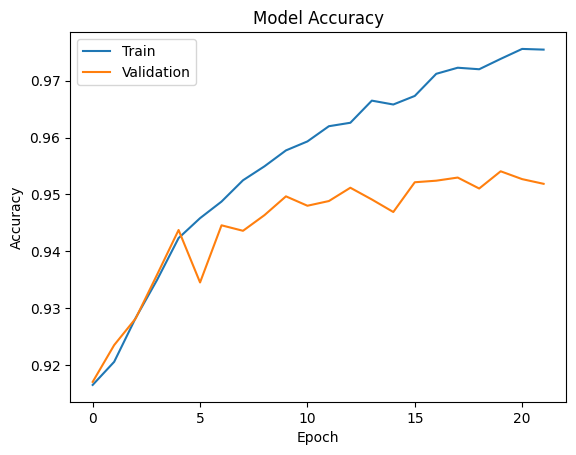

In [49]:
plt.plot(history_0.history['accuracy'])
plt.plot(history_0.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

These trends indicate that the model suffered some overfitting. However,we will conduct additional evaluations, such as testing the model on a separate test set  to further validate its performance and ensure that overfitting has not occurred

#### **Evaluating the model on test data**

In [50]:
metrics = model_0.evaluate(X_test_normalized, y_test_encoded, verbose=2)

23/23 - 2s - loss: 0.9716 - accuracy: 0.9538 - precision: 0.7454 - recall: 0.6774 - 2s/epoch - 95ms/step


The similarities between the test results and the validation results, along with the consistent trends observed during training, suggest that the model has successfully learned patterns in the data without overfitting.

### **Generating the predictions using test data**

In [51]:
# Here we would get the output as probablities for each category
y_pred=model_0.predict(X_test_normalized)

23/23 [==============================] - 4s 164ms/step


In [52]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

### **Plotting Confusion Matrix**

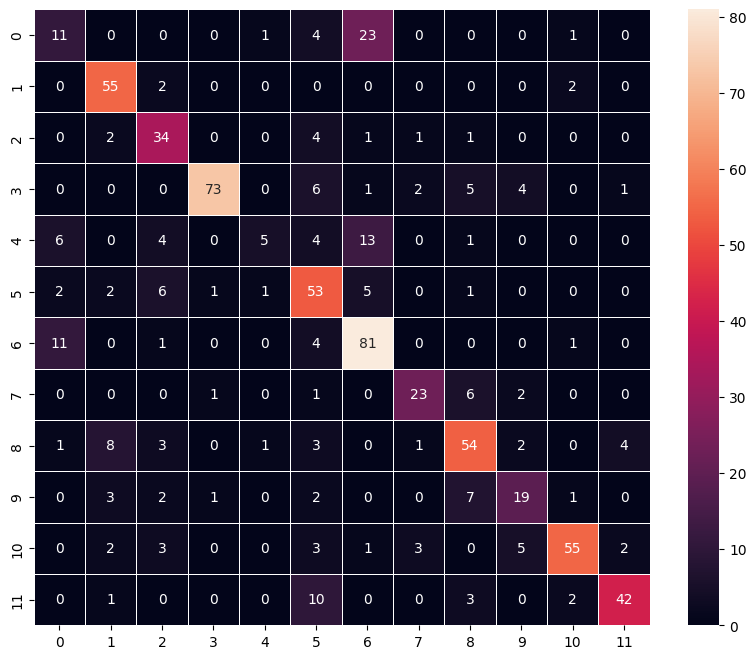

In [37]:
# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

<b> Observations</b><br>
- We observe that some of the classes are not predicted correctly.
- In comparison to the rest, we can see that classes 1,3,5,6,8, and 10 are well classified.
- We can also observe that classes 0 and 4 are mostly misclassified.

##### **We clear the previous model's history from the session.**.

In [38]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

#### **We fix the seed again after clearing the backend**

In [39]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

#### **Architecture 2**

- We add a third convolutional layer(128) and 128 neurons

In [26]:
# Intializing a sequential model

model = Sequential()
# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3,3), input_shape = (70,70,3), activation = "relu"))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D(2,2))# downsize the feature map extracted by the filters

# Adding second conv layer with 64 filters and kernel size 3x3 , padding 'same'
model.add(Conv2D(64, (3,3), activation = "relu"))

# Adding max pooling to reduce the size of output of second conv layer
model.add(MaxPooling2D(2,2))

# Adding third conv layer with 128 filters and kernel size 3x3 , padding 'same'
model.add(Conv2D(128, (3,3), activation = "relu"))

# Adding max pooling to reduce the size of output of third conv layer
model.add(MaxPooling2D(2,2))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 128 neurons
model.add(Dense (128, activation = "relu"))

# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(12, activation='softmax'))

In [27]:
# Generating the summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 68, 68, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 34, 34, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 128)       

In [31]:
# define model checkpoint
model_filepath = "/content/drive/MyDrive/ailead/Model"
chkpt1 = ModelCheckpoint(os.path.join(model_filepath, "plantspec.hdf5"), save_best_only = True, verbose = 2)

# define early stopping layer
es = EarlyStopping(patience = 3, monitor="val_loss", mode ="min", verbose = 2)

In [32]:
# Set the metrics
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
]

In [33]:
# Using Adam Optimizer
adam = Adam()

# Compile model
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=METRICS)

### <b> Fit the model on the train data

In [34]:
history = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=25,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2, callbacks =[chkpt1, es]
)

Epoch 1/25

Epoch 1: val_loss improved from inf to 1.69700, saving model to /content/drive/MyDrive/ailead/Model/plantspec.hdf5
108/108 - 66s - loss: 2.0676 - accuracy: 0.9177 - precision: 0.5729 - recall: 0.0493 - val_loss: 1.6970 - val_accuracy: 0.9233 - val_precision: 0.7500 - val_recall: 0.1188 - 66s/epoch - 607ms/step
Epoch 2/25

Epoch 2: val_loss improved from 1.69700 to 1.35933, saving model to /content/drive/MyDrive/ailead/Model/plantspec.hdf5
108/108 - 61s - loss: 1.5021 - accuracy: 0.9255 - precision: 0.6602 - recall: 0.2192 - val_loss: 1.3593 - val_accuracy: 0.9332 - val_precision: 0.7655 - val_recall: 0.2855 - 61s/epoch - 564ms/step
Epoch 3/25

Epoch 3: val_loss improved from 1.35933 to 1.10379, saving model to /content/drive/MyDrive/ailead/Model/plantspec.hdf5
108/108 - 59s - loss: 1.1317 - accuracy: 0.9404 - precision: 0.7528 - recall: 0.4235 - val_loss: 1.1038 - val_accuracy: 0.9440 - val_precision: 0.7519 - val_recall: 0.4901 - 59s/epoch - 546ms/step
Epoch 4/25

Epoch 4:

- Performance Metrics: While the model achieved high accuracy, precision, and recall values on the training data, the validation results show some fluctuations. The validation loss increased from 1.69700 in the first epoch to 0.79136 in the sixth epoch but did not improve further and started to increase again. The validation accuracy, precision, and recall reached 0.9594, 0.8200, and 0.6766, respectively.
- The model triggered early stopping in the 9th epoch, indicating that the validation loss did not improve significantly after that point. This suggests that the model may not have reached its optimal performance and could potentially benefit from further training or adjustments.
-  Given the decline in the validation loss and the lack of consistent improvement in validation metrics, it is possible that the model may have overfit the training data to some extent.
- We evaluate the model's performance on test set to determine its true generalization capabilities accurately..

We can say the model suggests potential overfitting

### **Model Evaluation**

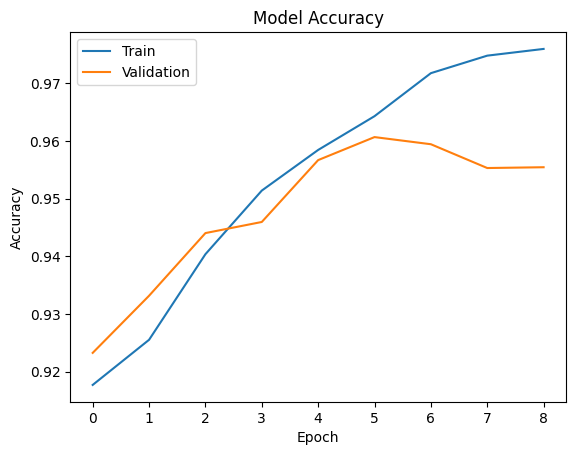

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:**



*   While the model achieved good performance on the training data, the decline in validation metrics suggests potential overfitting..


#### **Evaluating the model on test data**

In [37]:
metrics = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

23/23 - 3s - loss: 0.8436 - accuracy: 0.9597 - precision: 0.7893 - recall: 0.7041 - 3s/epoch - 139ms/step


- These evaluation metrics collectively demonstrate that the model generalizes well to the unseen test data. It achieves a high accuracy(higher than validation but lower than training), effectively minimizes errors, and demonstrates a good balance between precision and recall.
- These results suggest that the revised model generalizes well and performs better on the test data

### **Generating the predictions using test data**

In [38]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

23/23 [==============================] - 3s 107ms/step


### **Plotting the Confusion Matrix**

*   The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.
*   The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.
*   We will use the `argmax()` function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.


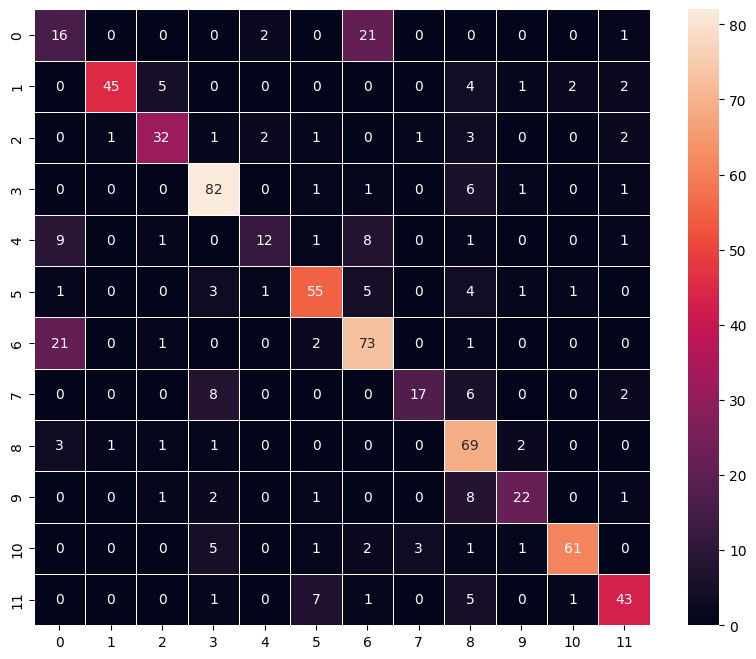

In [39]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

<b> Observations</b><br>
- We observe that Classes 0,3, 4, 8 and 10 did better indicating some improvement.

- 6th class has some misclassification.

- But generally this model outperformed the previous

#### **Architecture 3**

As we can see, our initial model appears to overfit. Therefore we'll try to address this problem with data augmentation and Batch Normalization to check if we can improve the above model's performance.

 ###### *** Clear the previous model's history from the session***.

In [107]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

#### **We fix the seed again after clearing the backend**

In [108]:
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [67]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=180,
                              fill_mode='nearest',
                              horizontal_flip = True,
                              vertical_flip = True,
                              shear_range = 0.2,
                              zoom_range = 0.2
                              )
#test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

Data augmentation is done on train dataset and not on in the validation/test data set.

In [71]:
# Intializing a sequential model
# model2 = Sequential()

# # Adding first conv layer with 128 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# # Input_shape denotes input image dimension images
# model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(60, 60, 3)))

# # Adding max pooling to reduce the size of output of first conv layer
# model2.add(MaxPooling2D((2, 2), padding = 'same'))
# model2.add(BatchNormalization()) # aid with overfitting
# model2.add(Dropout(0.1))

# # Adding second conv layer with 128 filters and kernel size 3x3 , padding 'same'
# model2.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
# model2.add(MaxPooling2D((2, 2), padding = 'same'))
# model2.add(BatchNormalization())
# model2.add(Dropout(0.1))

# # Adding third conv layer with 256 filters and kernel size 3x3 , padding 'same'
# model2.add(Conv2D(256, (3, 3), activation='relu', padding="same"))
# model2.add(MaxPooling2D((2, 2), padding = 'same'))
# model2.add(BatchNormalization())
# model2.add(Dropout(0.3))

# # flattening the output of the conv layer after max pooling to make it ready for creating dense connections
# model2.add(Flatten())

# # Adding a fully connected dense layer with 100 neurons
# model2.add(Dense(256, activation='relu'))
# model2.add(Dropout(0.3))
# # Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
# model2.add(Dense(12, activation='softmax'))


We also add padding = "same" and introduce dropout

In [68]:
model2 = Sequential()
# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model2.add(Conv2D(64, (3,3) ,padding="same", input_shape = (70,70,3), activation = "relu"))

# Adding max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D(2,2))# downsize the feature map extracted by the filters
#model2.add(BatchNormalization())
model2.add(Dropout(0.3))

# Adding second conv layer with 64 filters and kernel size 3x3 , padding 'same'
model2.add(Conv2D(64, (3,3), padding="same", activation = "relu"))

# Adding max pooling to reduce the size of output of second conv layer
model2.add(MaxPooling2D(2,2))
#model2.add(BatchNormalization())
model2.add(Dropout(0.3))

# Adding third conv layer with 128 filters and kernel size 3x3 , padding 'same'
model2.add(Conv2D(128, (3,3), activation = "relu"))

# Adding max pooling to reduce the size of output of third conv layer
model2.add(MaxPooling2D(2,2))
#model2.add(BatchNormalization())
model2.add(Dropout(0.3))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 100 neurons  and Dropout of 0.3
model2.add(Dense (128, activation = "relu"))
model2.add(Dropout(0.5))

# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model2.add(Dense(12, activation='softmax'))

In [57]:
# Generating the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 70, 70, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 35, 35, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 35, 35, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 35, 35, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 35, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 64)       0

In [69]:
# define model checkpoint
model2_filename = "/content/drive/MyDrive/ailead/Model/plant2spec.hdf5"
chkpt2 = ModelCheckpoint(model2_filename, save_best_only = True, verbose = 2)

# define early stopping layer
es2 = EarlyStopping(patience = 4, monitor= "val_loss",mode = "min", verbose = 2 )

In [70]:

# Using Adam Optimizer
adam = Adam()
# opt=Adam()


In [71]:
# Compile model
model2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=METRICS)

In [72]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history2 = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1, callbacks =[chkpt2, es2])

Epoch 1/25
53/53 [==============================] - ETA: 0s - loss: 2.4216 - accuracy: 0.9053 - precision: 0.0559 - recall: 0.0086
Epoch 1: val_loss improved from inf to 2.31075, saving model to /content/drive/MyDrive/ailead/Model/plant2spec.hdf5
53/53 [==============================] - 79s 1s/step - loss: 2.4216 - accuracy: 0.9053 - precision: 0.0559 - recall: 0.0086 - val_loss: 2.3107 - val_accuracy: 0.9167 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
53/53 [==============================] - ETA: 0s - loss: 2.0546 - accuracy: 0.9173 - precision: 0.5385 - recall: 0.0495
Epoch 2: val_loss improved from 2.31075 to 1.87479, saving model to /content/drive/MyDrive/ailead/Model/plant2spec.hdf5
53/53 [==============================] - 77s 1s/step - loss: 2.0546 - accuracy: 0.9173 - precision: 0.5385 - recall: 0.0495 - val_loss: 1.8748 - val_accuracy: 0.9204 - val_precision: 0.8140 - val_recall: 0.0578
Epoch 3/25
53/53 [==============================] - ETA: 0s - loss: 1.83

- Based on the provided information, it appears that the model has achieved high accuracy and has been able to generalize well to the validation dataset as it was higher than the training set. Throughout the training process, both the training accuracy and validation accuracy consistently improved, indicating that the Model2 learned from the training data and was able to apply that knowledge effectively to unseen data.
- The precision metric shows that the precision values improved over time, which suggests that the model became better at minimizing false positive predictions.

- The recall values also improved during training, indicating that the model became more effective at capturing true positive cases.

- Regarding the validation loss, we observe that it decreased consistently from epoch to epoch, indicating that the model's predictions became more accurate on unseen data. This is a positive trend and suggests that the model was able to generalize well to new, unseen examples

- We shall assess test dataset and analyze the learning curve to ensure the absence of overfitting.

**NB: We commented out Batchnormalization because the model was not performing well with batch nomalization**

#### **Model Evaluation**

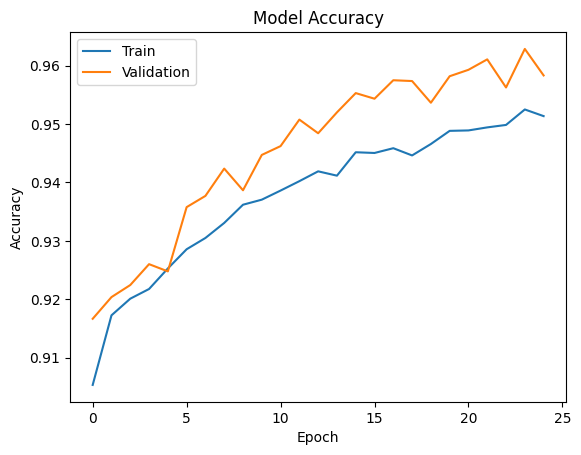

In [73]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

We can observe that our metrics improved especially on validation compared to our previous model. Validation performed best using data augmentation as validation accuracy was higher than training accuracy

#### **Evaluating the model on test data**

In [80]:
Metrics = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

23/23 - 3s - loss: 0.8239 - accuracy: 0.9587 - precision: 0.8614 - recall: 0.6017 - 3s/epoch - 128ms/step


Overall, the evaluation metrics on the test dataset are consistent with the model's performance on the validation dataset, suggesting that the model generalizes well to unseen data.

### **Generating the predictions using test data**

In [81]:
# Here we would get the output as probablities for each category
y_pred2=model2.predict(X_test_normalized)

23/23 [==============================] - 3s 136ms/step


In [82]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred2_arg=np.argmax(y_pred2,axis=1)
y_test2_arg=np.argmax(y_test_encoded,axis=1)


### **Plotting Confusion Matix**

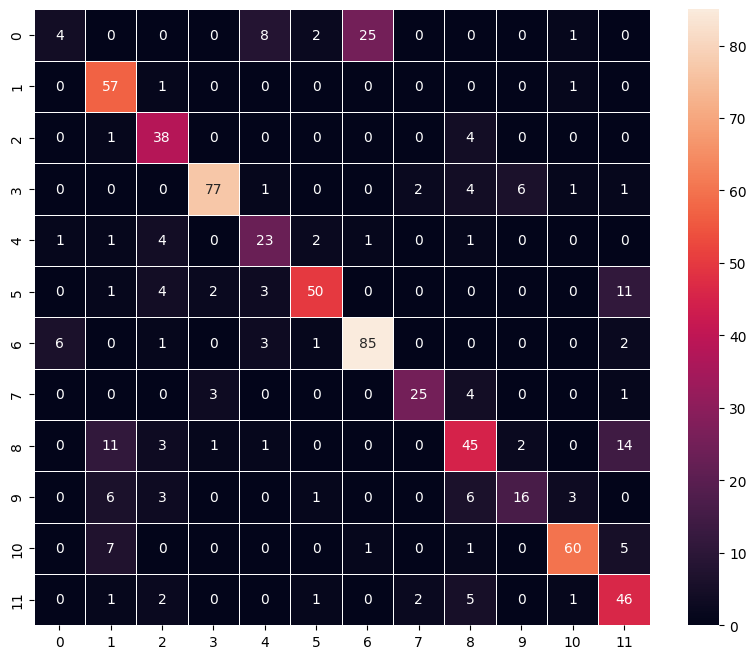

In [83]:
# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test2_arg,y_pred2_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

**Observation:**
- There is noticeable improvement in the confusion matrix, although some confusion remains with the plant species belonging to classes 0, 5, and 8.
- Class 0 exhibits the highest degree of confusion compared to other classes.
- It is evident that this model has achieved superior performance compared to our previous model as misclassification is less.

# Transfer Learning using VGG19

- To improve our model, we will employ transfer learning by utilizing the VGG19 architecture, which has been pre-trained on the ImageNet dataset. Instead of training the convolutional and pooling layers from scratch, we will load the pre-trained weights and freeze them to retain their learned features. However, we will modify the fully-connected layers to suit our specific classification problem. This approach allows us to benefit from the knowledge and feature extraction capabilities of VGG19 while adapting it to our own task


In [84]:
from tensorflow.keras.models import Model
from keras.applications.vgg19 import VGG19

vgg19_model = VGG19(weights='imagenet', include_top = False, input_shape = (70,70,3))
vgg19_model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 70, 70, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 70, 70, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 70, 70, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 35, 35, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 35, 35, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 35, 35, 128)       147584    
                                                              

In [85]:
# Making all the layers of the VGG19 model non-trainable. i.e. freezing them
for layer in vgg19_model.layers:
    layer.trainable = False

### **Architecture 3**

In [86]:
# define the architecture
new_model = Sequential()

# Adding the convolutional part of the VGG19 model from above
new_model.add(vgg19_model)

# Flattening the output of the VGG19 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer (our FCN)
new_model.add(Dense(512, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(32, activation='relu'))

# Add the final layer
new_model.add(Dense(12, activation='softmax'))


In [87]:
# Generating the summary of the model
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 32)                16416     
                                                                 
 dense_4 (Dense)             (None, 12)                396       
                                                                 
Total params: 21,090,284
Trainable params: 1,065,900
N

In [88]:
# define model checkpoint
new_model_filename = "/content/drive/MyDrive/ailead/Model/plant3spec.hdf5"
chkpt3 = ModelCheckpoint(new_model_filename, save_best_only = True, verbose = 2)

# define early stopping layer
es2 = EarlyStopping(patience = 4, monitor= "val_loss",mode = "min", verbose = 2 )

In [89]:
# Using Adam Optimizer
adam = Adam()

# Compile model
new_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=METRICS)

In [90]:
# Epochs
epochs = 15
# Batch size
batch_size = 64

history_vgg19 = new_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1, callbacks =[chkpt3, es2])

Epoch 1/15
53/53 [==============================] - ETA: 0s - loss: 2.2522 - accuracy: 0.9241 - precision: 0.7920 - recall: 0.1213
Epoch 1: val_loss improved from inf to 1.99407, saving model to /content/drive/MyDrive/ailead/Model/plant3spec.hdf5
53/53 [==============================] - 350s 7s/step - loss: 2.2522 - accuracy: 0.9241 - precision: 0.7920 - recall: 0.1213 - val_loss: 1.9941 - val_accuracy: 0.9175 - val_precision: 0.7500 - val_recall: 0.0149
Epoch 2/15
53/53 [==============================] - ETA: 0s - loss: 1.9281 - accuracy: 0.9184 - precision: 0.5989 - recall: 0.0630
Epoch 2: val_loss improved from 1.99407 to 1.76685, saving model to /content/drive/MyDrive/ailead/Model/plant3spec.hdf5
53/53 [==============================] - 327s 6s/step - loss: 1.9281 - accuracy: 0.9184 - precision: 0.5989 - recall: 0.0630 - val_loss: 1.7669 - val_accuracy: 0.9190 - val_precision: 0.6889 - val_recall: 0.0512
Epoch 3/15
53/53 [==============================] - ETA: 0s - loss: 1.7641 - a

- The model shows improvements in various metrics as the epochs progress. The loss decreases over time, indicating that the model is learning and making better predictions. The accuracy increases, indicating that the model is becoming more accurate in classifying the plant species. The precision and recall also show improvements, indicating that the model is better at correctly identifying the different classes

- Overall, though VGG19 model performed, Model2 did better hence there is still room for enhancement, particularly in addressing confusion between certain plant species

### **Evaluating Model**

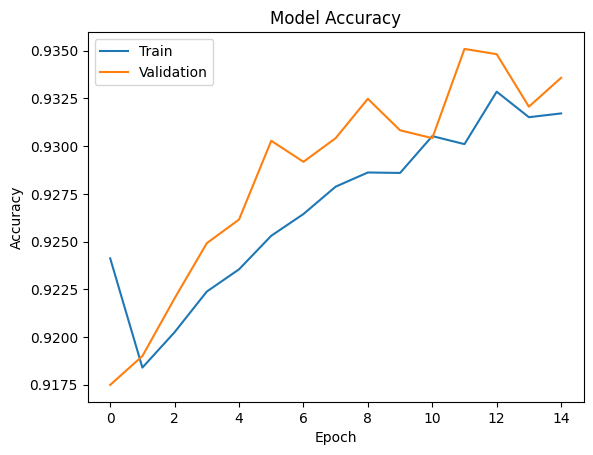

In [91]:
plt.plot(history_vgg19.history['accuracy'])
plt.plot(history_vgg19.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


#### **Evaluating the test dataset**

In [92]:
metrics = new_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

23/23 - 51s - loss: 1.2558 - accuracy: 0.9365 - precision: 0.7457 - recall: 0.3619 - 51s/epoch - 2s/step


 There is still room for improvement particularly in correctly identifying certain plant species

### **Generating the predictions using test data**

In [93]:
# Here we would get the output as probablities for each category
y_pred=new_model.predict(X_test_normalized)

23/23 [==============================] - 50s 2s/step


### **Plotting Confusion Matrix**

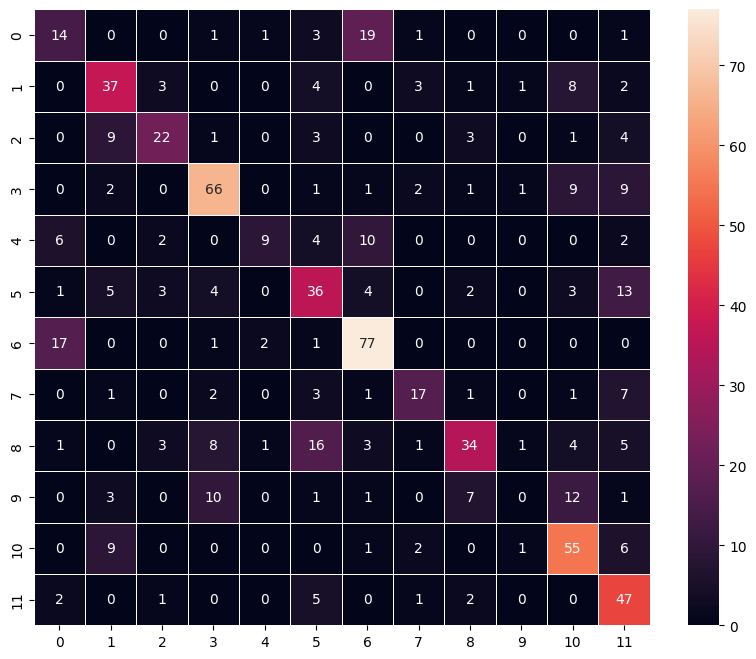

In [94]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

- it is observed e that the performance of the model may still have room for improvement. For example, the recall values for some classes 0, 4, 5, 6, 8 and 9 had a high number of misclassification, indicating that the model is struggling to correctly identify those specific classes. Further fine-tuning or adjustments may be necessary to address this issue


- Thus we can say that CNN Model that was tuned or Architecture 2 confusion matrix had the best classification followed by CNN with Data Augmentation.

In [98]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16


In [99]:
vgg16_model = VGG16(weights='imagenet', include_top = False, input_shape = (70,70,3))
vgg16_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 70, 70, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 70, 70, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 70, 70, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 35, 35, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 35, 35, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 35, 35, 128)       147584    
                                                              

# Transfer Learning using VGG16

- We will use VGG 16 on original data and not the augmented data for comparison

In [109]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg16_model.layers:
    layer.trainable = False

In [114]:
# Define Model
new_vgg_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_vgg_model.add(vgg16_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_vgg_model.add(Flatten())

# Adding a dense output layer
new_vgg_model.add(Dense(128, activation='relu'))
new_vgg_model.add(Dropout(0.5))
new_vgg_model.add(Dense(64, activation='relu'))

# Add final layer
new_vgg_model.add(Dense(12, activation='softmax'))


In [115]:
# Generating the summary of the model
new_vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 12)                780       
                                                                 
Total params: 14,985,996
Trainable params: 271,308
Non

In [117]:
# define model checkpoint
new_vgg_model_filename = "/content/drive/MyDrive/ailead/Model/plant4spec.hdf5"
chkpt4 = ModelCheckpoint(new_vgg_model_filename, save_best_only = True, verbose = 2)

# define early stopping layer
es4= EarlyStopping(patience = 5, monitor= "val_loss",mode = "min", verbose = 2 )

In [118]:
# Using Adam Optimizer
adam = Adam()

# Compile model
new_vgg_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=METRICS)

In [119]:
history_new_vgg_model = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=10,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=64,
            verbose=2, callbacks =[chkpt4, es4]
)

Epoch 1/10

Epoch 1: val_loss improved from inf to 0.91543, saving model to /content/drive/MyDrive/ailead/Model/plant4spec.hdf5
54/54 - 64s - loss: 0.2106 - accuracy: 0.9891 - precision: 0.9494 - recall: 0.9184 - val_loss: 0.9154 - val_accuracy: 0.9609 - val_precision: 0.7785 - val_recall: 0.7426 - 64s/epoch - 1s/step
Epoch 2/10

Epoch 2: val_loss did not improve from 0.91543
54/54 - 77s - loss: 0.1953 - accuracy: 0.9896 - precision: 0.9529 - recall: 0.9201 - val_loss: 0.9369 - val_accuracy: 0.9616 - val_precision: 0.7824 - val_recall: 0.7475 - 77s/epoch - 1s/step
Epoch 3/10

Epoch 3: val_loss did not improve from 0.91543
54/54 - 62s - loss: 0.1648 - accuracy: 0.9907 - precision: 0.9546 - recall: 0.9324 - val_loss: 0.9721 - val_accuracy: 0.9592 - val_precision: 0.7696 - val_recall: 0.7277 - 62s/epoch - 1s/step
Epoch 4/10

Epoch 4: val_loss did not improve from 0.91543
54/54 - 61s - loss: 0.1555 - accuracy: 0.9917 - precision: 0.9623 - recall: 0.9376 - val_loss: 1.0579 - val_accuracy: 0

The model achieved high accuracy, precision, and recall on both the training and validation sets. However, the validation loss did not improve after the first epoch, indicating that the model's performance did not improve significantly beyond that point. As a result, early stopping was triggered, and training was stopped to prevent overfitting.

#### **Evaluating Model**

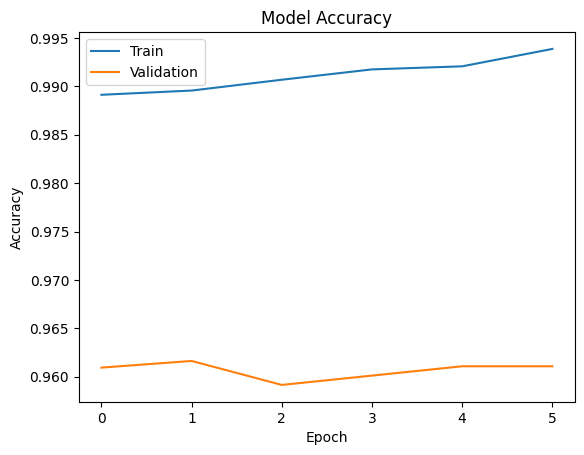

In [120]:
plt.plot(history_new_vgg_model.history['accuracy'])
plt.plot(history_new_vgg_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Though the metric values tend to be higher than all previous models, Visualizing the model indicates model is not generalization. The model suffers from overfitting which will cause a misclassification of the plant specie classes

##### **Evaluating model on test dataset**

In [121]:
Metrics = new_vgg_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

23/23 - 42s - loss: 2.5164 - accuracy: 0.9233 - precision: 0.7457 - recall: 0.1206 - 42s/epoch - 2s/step


The test dataset did not perfm well compared to previous models. The VGG19 performed better interms of Transfer learning models

In [122]:
# Here we would get the output as probablities for each category
y_pred=new_vgg_model.predict(X_test_normalized)

23/23 [==============================] - 39s 2s/step


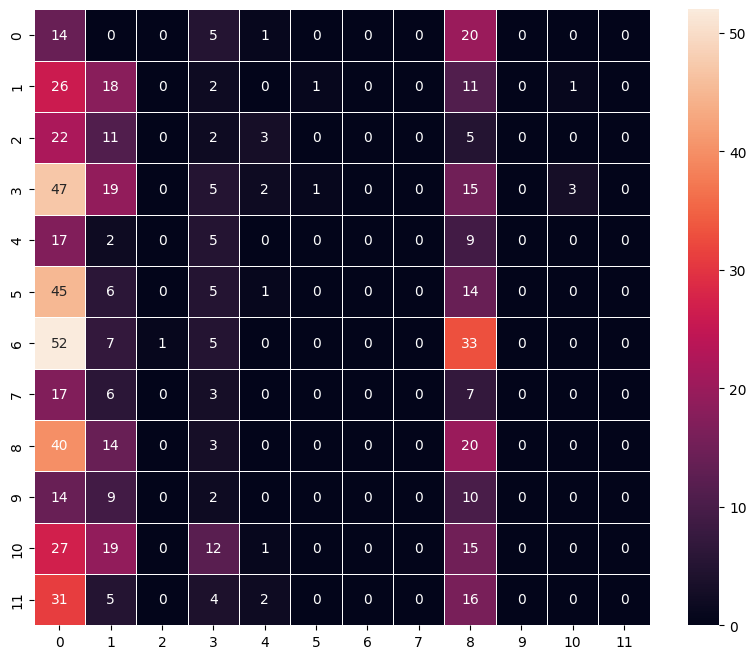

In [123]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
    )
plt.show()

We observe a bad case of misclassification when we used VGG 16 on original data set

# **Visualizing the prediction:**

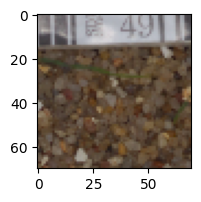

1/1 [==============================] - 0s 141ms/step
Predicted Label ['Scentless Mayweed']
True Label Black-grass


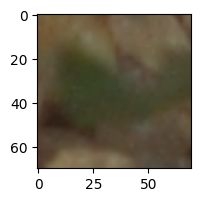

1/1 [==============================] - 0s 75ms/step
Predicted Label ['Scentless Mayweed']
True Label Common wheat


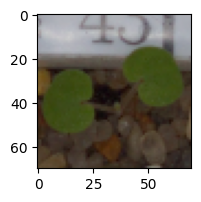

1/1 [==============================] - 0s 90ms/step
Predicted Label ['Black-grass']
True Label Small-flowered Cranesbill


In [124]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[5])
plt.show()
print('Predicted Label', enc.inverse_transform(new_vgg_model.predict((X_test_normalized[5].reshape(1,70,70,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[5])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[38])
plt.show()
print('Predicted Label', enc.inverse_transform(new_vgg_model.predict((X_test_normalized[38].reshape(1,70,70,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[38])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[12])
plt.show()
print('Predicted Label', enc.inverse_transform(new_vgg_model.predict((X_test_normalized[12].reshape(1,70,70,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[12])

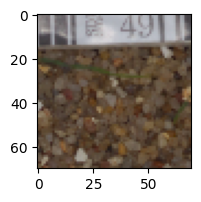

1/1 [==============================] - 0s 88ms/step
Predicted Label ['Black-grass']
True Label Black-grass


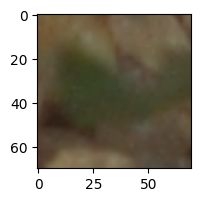

1/1 [==============================] - 0s 48ms/step
Predicted Label ['Common wheat']
True Label Common wheat


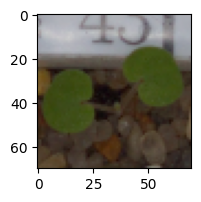

1/1 [==============================] - 0s 42ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


In [95]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[5])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[5].reshape(1,70,70,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[5])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[38])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[38].reshape(1,70,70,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[38])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[12])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[12].reshape(1,70,70,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[12])

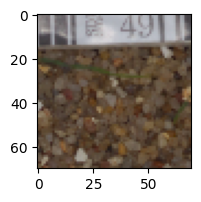

1/1 [==============================] - 0s 44ms/step
Predicted Label ['Loose Silky-bent']
True Label Black-grass


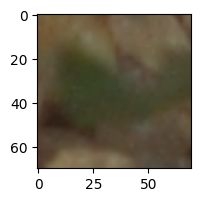

1/1 [==============================] - 0s 45ms/step
Predicted Label ['Common wheat']
True Label Common wheat


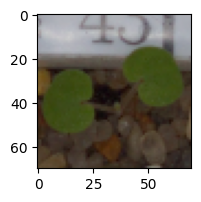

1/1 [==============================] - 0s 42ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


In [96]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[5])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[5].reshape(1,70,70,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[5])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[38])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[38].reshape(1,70,70,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[38])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[12])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[12].reshape(1,70,70,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[12])

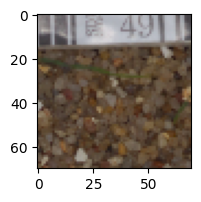

1/1 [==============================] - 0s 176ms/step
Predicted Label ['Fat Hen']
True Label Scentless Mayweed


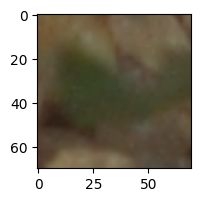

1/1 [==============================] - 0s 165ms/step
Predicted Label ['Charlock']
True Label Charlock


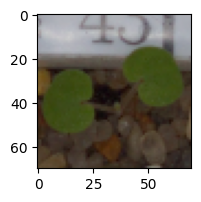

1/1 [==============================] - 0s 172ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


In [97]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[5])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[2].reshape(1,70,70,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[38])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[33].reshape(1,70,70,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[12])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[36].reshape(1,70,70,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])

## Conclusion
- We can observe from the confusion matrix of all the models,  that our Architecture 2 model was the best model because it predicted the majority of the classes better than the other models. VGG16 failed to do correct classification despite the high metric values in trainining and validation
- The test accuracy of the VGG19 model is 93.65% whereas it was 95.97 for our tuned base CNN model.
- Data Augmentation may have helped in improving the model.


In [128]:
pd.DataFrame({'Models':['Base_CNN_Model','Base_CNN_Tuned', 'CNN Model with Data Augmentation','Transfer Learning Model(VGG19)','Transfer Learning Model(VGG16)'],'Train Accuracy':['97.54%','97.60%','95.14%','93.17', '99.39'],'Validation Accuracy':['95.19%','95.54%','95.87%','93.36', '96.11'],'Test Accuracy':['95.38%','95.97%','95.87%','93.65', '92.33']})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Base_CNN_Model,97.54%,95.19%,95.38%
1,Base_CNN_Tuned,97.60%,95.54%,95.97%
2,CNN Model with Data Augmentation,95.14%,95.87%,95.87%
3,Transfer Learning Model(VGG19),93.17,93.36,93.65
4,Transfer Learning Model(VGG16),99.39,96.11,92.33


## Scope of Improvement
- These models can be further improved by training with different filter sizes and different number of filters.
- These models can also be trained on the original image_size i.e 128 x 128 rather than being reduced to 70.
- Data Augmentation can be performed more and dropout_rate can be changed to improve the model performance.
- Other Transfer Learning architectures can also be used to train the CNN model and these models can be used for classification.